In [2]:
#Install Dataset and import requirements
!pip install -q gdown
import gdown
import zipfile
import os

file_id = "1BYLz8QCTjIvGTW3b-g0okooNZLJd4ykz"
url = f"https://drive.google.com/uc?id={file_id}"

output = "e-waste-dataset.zip"
folder = "e-waste-dataset"

if not os.path.exists(folder):
    print("Downloading dataset")
    gdown.download(url, output, quiet=False)

    print("Unzipping dataset")
    with zipfile.ZipFile(output, "r") as zip_ref:
        zip_ref.extractall(".")
    os.remove(output)
    print("Dataset ready!")
else:
    print("Dataset already exists.")


Downloading...
From: https://drive.google.com/uc?id=1BYLz8QCTjIvGTW3b-g0okooNZLJd4ykz
To: /content/e-waste-dataset.zip
100%|██████████| 12.4M/12.4M [00:00<00:00, 35.8MB/s]


Unzipping dataset
Dataset ready!


In [2]:
!pip install tensorflow

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr
from PIL import Image
import time

In [3]:
base_dir = "modified-dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


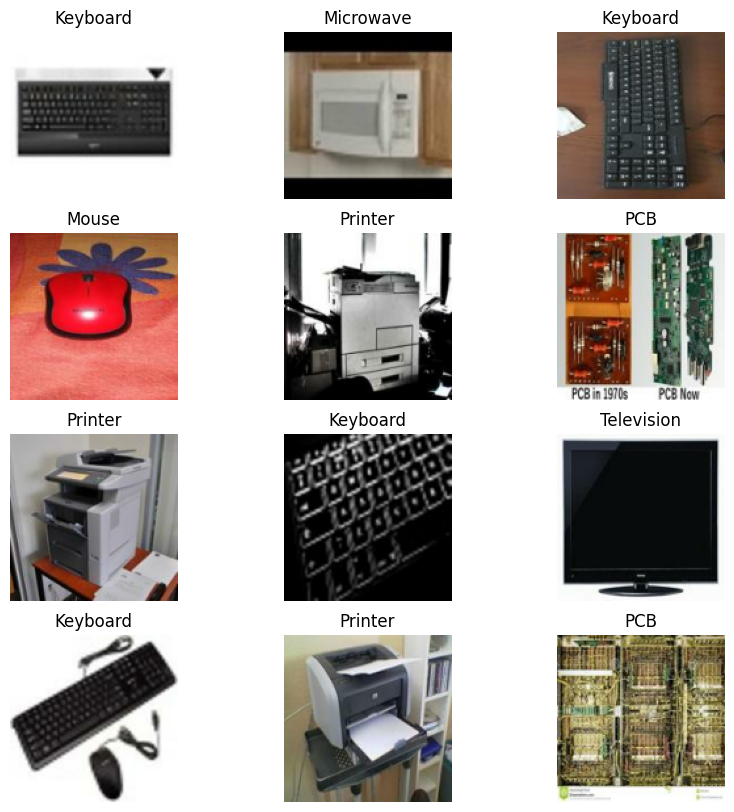

In [4]:
#EDA and Data Augmentation
datatrain= tf.keras.utils.image_dataset_from_directory(train_dir, shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)
datavalid = tf.keras.utils.image_dataset_from_directory(val_dir,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)
datatest=tf.keras.utils.image_dataset_from_directory(test_dir,shuffle = False, image_size = (128,128), batch_size = 32, validation_split= False)

print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [5]:
#Model Selection and Training
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape = (128, 128, 3),
    include_top = False,
    weights = 'imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (128, 128, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation = 'softmax')
])
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['Accuracy'])

#callback to stop training if validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True
)

#Training
epochs = 15
start_time = time.time()
history = model.fit(
    datatrain,
    validation_data = datavalid,
    epochs = epochs,
    batch_size = 100,
    callbacks = [early]
)
end_time = time.time()
print(f"Training completed in {end_time - start_time} seconds")

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 51s 147ms/step - Accuracy: 0.2500 - loss: 2.1075 - val_Accuracy: 0.7733 - val_loss: 1.1049
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - Accuracy: 0.7858 - loss: 0.9754 - val_Accuracy: 0.8967 - val_loss: 0.5191
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - Accuracy: 0.8826 - loss: 0.4828 - val_Accuracy: 0.9367 - val_loss: 0.3031
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - Accuracy: 0.9029 - loss: 0.3503 - val_Accuracy: 0.9533 - val_loss: 0.2243
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - Accuracy: 0.9233 - loss: 0.2615 - val_Accuracy: 0.9567 - val_loss: 0.1897
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - Accuracy: 0.9488 - loss: 0.1833 - val_Accuracy: 0.9467 - val_loss: 0.1739
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - Accuracy: 0.9413 - loss: 0.1849 - val_Accuracy: 0.9633 - val_loss: 0.1557
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - Accu